# Business goal:

Make sure you've understood the big picture of your project: the goal of the company (Gnod), their current product (Gnoosic), their strategy, and how your project fits into this context. Re-read the business case and the e-mail from the CTO, take a look at the flowchart and create an initial Trello board with the tasks you think you'll have to acomplish.

# Scraping popular songs:

Your product will take a song as an input from the user and will output another song (the recommendation). In most cases, the recommended song will have to be similar to the inputed song, but the CTO thinks that if the song is on the top charts at the moment, the user will enjoy more a recommendation of a song that's also popular at the moment.

You have find data on the internet about currently popular songs. Billboard mantains a weekly Top 100 of "hot" songs here: https://www.billboard.com/charts/hot-100. 

It's a good place to start! Scrape the current top 100 songs and their respective artists, and put the information into a pandas dataframe.

In [1]:
# 1. import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [2]:
# 2. find url and store it in a variable
url = "https://www.billboard.com/charts/hot-100"

In [3]:
# 3. download html with a get request
response = requests.get(url)
response.status_code # 200 status code means OK!

200

In [4]:
# 4.1. parse html (create the 'soup')
soup = BeautifulSoup(response.content, "html.parser")

In [5]:
#soup.select("div > ol")

In [6]:
titles = []

for i in soup.find_all("span", {"class":"chart-element__information__song text--truncate color--primary"}):
    #print(i.get_text())
    titles.append(i.get_text())


In [7]:
artists = []

for i in soup.find_all("span", {"class":"chart-element__information__artist text--truncate color--secondary"}):
    #print(i.get_text())
    artists.append(i.get_text())

In [8]:
weeks_in_chart = []

for i in soup.find_all("span", {"chart-element__information__delta__text text--week"}):
    #print(i.get_text())
    weeks_in_chart.append(i.get_text())

In [9]:
peak = []

for i in soup.find_all("span", {"chart-element__meta text--center color--secondary text--peak"}):
    #print(i.get_text())
    peak.append(i.get_text())

In [10]:
last_week = []

for i in soup.find_all("span", {"chart-element__information__delta__text text--last"}):
    #print(i.get_text())
    last_week.append(i.get_text())

In [11]:
ranking = []

for i in soup.find_all("span", {"chart-element__rank__number"}):
    #print(i.get_text())
    ranking.append(i.get_text())

In [12]:
billboard = pd.DataFrame({"title":titles,
                       "artist":artists,
                          "ranking":ranking,
                       "weeks in chart":weeks_in_chart,
                          "peak":peak,
                          "last week":last_week
                      })                         

In [13]:
billboard['title']=billboard['title'].apply(lambda x: x.title())
billboard['artist']=billboard['artist'].apply(lambda x: x.title())

In [14]:
billboard.sort_values(by="ranking",ascending=True)

,title,artist,ranking,weeks in chart,peak,last week
0,Montero (Call Me By Your Name),Lil Nas X,1,1 Weeks on Chart,1,- Last Week
9,What You Know Bout Love,Pop Smoke,10,30 Weeks on Chart,9,9 Last Week
99,Girl Like Me,Black Eyed Peas X Shakira,100,12 Weeks on Chart,67,89 Last Week
10,Tombstone,Rod Wave,11,2 Weeks on Chart,11,82 Last Week
11,Astronaut In The Ocean,Masked Wolf,12,7 Weeks on Chart,12,17 Last Week
...,...,...,...,...,...,...
94,One Too Many,Keith Urban Duet With P!Nk,95,16 Weeks on Chart,62,90 Last Week
95,Shock Da World,Rod Wave,96,1 Weeks on Chart,96,- Last Week
96,You Got It,Vedo,97,14 Weeks on Chart,75,88 Last Week
97,Sneaky Links,Rod Wave,98,1 Weeks on Chart,98,- Last Week


## Bonus

Can you find other websites with lists of "hot" songs? What about songs that were popular on a certain decade? 

You can scrape more lists and add extra features to the project.

-------------------------------------------------------------------------------------------------------------------------------

# Spotipy

-------------------------------------------------------------------------------------------------------------------------------

In [15]:
!pip install spotipy

In [16]:
# Importing libraries

from config import *                   

import json
import spotipy

from spotipy.oauth2 import SpotifyClientCredentials

In [17]:
# To initialize spotipy with the user credentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID, client_secret=Client_Secret_ID))


-------------------------------------------------------------------------------------------------------------------------------

## Functions

-------------------------------------------------------------------------------------------------------------------------------

In [18]:
#Function to read a whole playlist from Spotify. We need the playlist ID and it returns a list of tracks

def get_playlist_tracks(username,playlist_id):
    
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID, client_secret=Client_Secret_ID))
    
    results = sp.user_playlist_tracks(username,playlist_id)
    
    tracks = results["items"]
    
    while results["next"]:
        results = sp.next(results)
        tracks.extend(results["items"])
        
    return tracks

--------------------------------------------------------------------------------------------------------------------------------

In [19]:
#Function to get the values from the tracks . We input a list of tracks and it returns a df

def get_values(playlist_list):


    song_names = []
    artist_names = []
    song_uri = []
    song_uri_total = []
    song_features = []
    

    counter = 0

    for item in playlist_list:
        
        try:
            
            counter = counter + 1 
    
            song_names.append(item['track']['name'])
    
            song_uri_total.append(item['track']['uri'])
    
            song_uri.append(item['track']['uri'])
        
    
            tempo_artists = []
            for artist in item['track']['artists']:
                tempo_artists.append(artist['name'])
    
            artist_names.append(tempo_artists)
    
            if counter == 100:
                song_features.append(sp.audio_features(song_uri))
                counter = 0
                song_uri = []
                
        except TypeError:
            
            continue
            
            
    song_features.append(sp.audio_features(song_uri))
    
    #print(artist_names)
    #artist_names = np.array(artist_names).flatten().tolist()
    
    song_id_total = [ uri[14:] for uri in song_uri_total ]
    
    song_features_total = [item for songs in song_features for item in songs]
    
    artist_names = [", ".join(artist) for artist in artist_names]
    
    my_dict = {'title': song_names, 'artist': artist_names, 'uri': song_uri_total,'features': song_features_total }  
    
    songs_df = pd.DataFrame(my_dict)
    
    songs_df = pd.concat([songs_df.drop(columns='features'),songs_df['features'].apply(pd.Series)],axis=1)
    
    return songs_df

----------------------------------------------------------------------------------------------------------------------------

In [20]:
#funcion  to get audio features basandandos en el Uri

def audio_features(x):
    
    song = sp.search(q = x, limit = 1) 
    uri = song["tracks"]["items"][0]["uri"]
    
    
    audiofeatures = sp.audio_features(uri)[0]
    

    song_df = pd.DataFrame(audiofeatures,index=[0])
    
    song_df = song_df.drop(columns=['key','type','uri','id','mode','track_href','analysis_url','duration_ms','time_signature'])
    
    #songs_df = pd.concat([songs_df.drop(columns='Features'),songs_df['Features'].apply(pd.Series)],axis=1)
    
    return song_df

    
    

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

## Data gathering

-------------------------------------------------------------------------------------------------------------------------------

In [21]:
#Best Hits 2021

play1 = get_playlist_tracks("spotify", "4hMcqod7ERKJ9mtjgdimeV")

In [22]:
df1 = get_values(play1)

df1.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Peaches (feat. Daniel Caesar & Giveon),"Justin Bieber, Daniel Caesar, Giveon",spotify:track:4iJyoBOLtHqaGxP12qzhQI,0.677,0.696,0,-6.181,1,0.1190,0.3210,...,0.420,0.464,90.030,audio_features,4iJyoBOLtHqaGxP12qzhQI,spotify:track:4iJyoBOLtHqaGxP12qzhQI,https://api.spotify.com/v1/tracks/4iJyoBOLtHqa...,https://api.spotify.com/v1/audio-analysis/4iJy...,198082,4
1,telepatía,Kali Uchis,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,0.653,0.524,11,-9.016,0,0.0502,0.1120,...,0.203,0.553,83.970,audio_features,6tDDoYIxWvMLTdKpjFkc1B,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,https://api.spotify.com/v1/tracks/6tDDoYIxWvML...,https://api.spotify.com/v1/audio-analysis/6tDD...,160191,4
2,Save Your Tears,The Weeknd,spotify:track:5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.0212,...,0.543,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
3,MONTERO (Call Me By Your Name),Lil Nas X,spotify:track:3BZEcbdtXQSo7OrvKRJ6mb,0.610,0.508,8,-6.682,0,0.1520,0.2970,...,0.384,0.758,178.818,audio_features,3BZEcbdtXQSo7OrvKRJ6mb,spotify:track:3BZEcbdtXQSo7OrvKRJ6mb,https://api.spotify.com/v1/tracks/3BZEcbdtXQSo...,https://api.spotify.com/v1/audio-analysis/3BZE...,137876,4
4,drivers license,Olivia Rodrigo,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.7210,...,0.105,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4


---------------------------------------------------------------------------------------------------------------------------

In [23]:
#Top songs 2000-2021

play2 = get_playlist_tracks("spotify", "7HP1rgWfJcGKHYCFt0cnYH")

In [24]:
df2 = get_values(play2)

df2.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Talk Dirty (feat. 2 Chainz),"Jason Derulo, 2 Chainz",spotify:track:5l3CML2OnzfNs5RfVgbcLt,0.760,0.652,6,-7.321,1,0.2320,0.034800,...,0.3070,0.759,100.315,audio_features,5l3CML2OnzfNs5RfVgbcLt,spotify:track:5l3CML2OnzfNs5RfVgbcLt,https://api.spotify.com/v1/tracks/5l3CML2OnzfN...,https://api.spotify.com/v1/audio-analysis/5l3C...,177685,4
1,HUMBLE.,Kendrick Lamar,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,0.908,0.621,1,-6.638,0,0.1020,0.000282,...,0.0958,0.421,150.011,audio_features,7KXjTSCq5nL1LoYtL7XAwS,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,https://api.spotify.com/v1/tracks/7KXjTSCq5nL1...,https://api.spotify.com/v1/audio-analysis/7KXj...,177000,4
2,Mirrors,Justin Timberlake,spotify:track:4rHZZAmHpZrA3iH5zx8frV,0.574,0.512,5,-6.664,0,0.0503,0.234000,...,0.0946,0.512,76.899,audio_features,4rHZZAmHpZrA3iH5zx8frV,spotify:track:4rHZZAmHpZrA3iH5zx8frV,https://api.spotify.com/v1/tracks/4rHZZAmHpZrA...,https://api.spotify.com/v1/audio-analysis/4rHZ...,484147,4
3,Thunder,Imagine Dragons,spotify:track:1zB4vmk8tFRmM9UULNzbLB,0.605,0.822,0,-4.833,1,0.0438,0.006710,...,0.1470,0.288,167.997,audio_features,1zB4vmk8tFRmM9UULNzbLB,spotify:track:1zB4vmk8tFRmM9UULNzbLB,https://api.spotify.com/v1/tracks/1zB4vmk8tFRm...,https://api.spotify.com/v1/audio-analysis/1zB4...,187147,4
4,Believer,Imagine Dragons,spotify:track:0pqnGHJpmpxLKifKRmU6WP,0.776,0.780,10,-4.374,0,0.1280,0.062200,...,0.0810,0.666,124.949,audio_features,0pqnGHJpmpxLKifKRmU6WP,spotify:track:0pqnGHJpmpxLKifKRmU6WP,https://api.spotify.com/v1/tracks/0pqnGHJpmpxL...,https://api.spotify.com/v1/audio-analysis/0pqn...,204347,4


-------------------------------------------------------------------------------------------------------------------------------

In [25]:
#Best of 80's

play3 = get_playlist_tracks("spotify", "6RGKHL5iSqwJ8xv1zDj228")

In [26]:
df3 = get_values(play3)
df3.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Tainted Love,Soft Cell,spotify:track:0cGG2EouYCEEC3xfa0tDFV,0.500,0.501,0,-8.284,0,0.0376,0.4620,...,0.2600,0.623,144.438,audio_features,0cGG2EouYCEEC3xfa0tDFV,spotify:track:0cGG2EouYCEEC3xfa0tDFV,https://api.spotify.com/v1/tracks/0cGG2EouYCEE...,https://api.spotify.com/v1/audio-analysis/0cGG...,153800,4
1,Sweet Dreams (Are Made of This) - Remastered,"Eurythmics, Annie Lennox, Dave Stewart",spotify:track:1TfqLAPs4K3s2rJMoCokcS,0.692,0.711,0,-7.498,0,0.0317,0.2250,...,0.1200,0.875,125.135,audio_features,1TfqLAPs4K3s2rJMoCokcS,spotify:track:1TfqLAPs4K3s2rJMoCokcS,https://api.spotify.com/v1/tracks/1TfqLAPs4K3s...,https://api.spotify.com/v1/audio-analysis/1Tfq...,216933,4
2,Smalltown Boy,Bronski Beat,spotify:track:0FrCX7P2C2hcRTcuhjEvK4,0.679,0.564,10,-11.247,1,0.0267,0.5290,...,0.2750,0.926,134.586,audio_features,0FrCX7P2C2hcRTcuhjEvK4,spotify:track:0FrCX7P2C2hcRTcuhjEvK4,https://api.spotify.com/v1/tracks/0FrCX7P2C2hc...,https://api.spotify.com/v1/audio-analysis/0FrC...,303307,4
3,Maniac,Michael Sembello,spotify:track:1xPSDf8z4dH46gkvlLtvDO,0.617,0.533,3,-11.516,0,0.0651,0.0891,...,0.0415,0.835,158.860,audio_features,1xPSDf8z4dH46gkvlLtvDO,spotify:track:1xPSDf8z4dH46gkvlLtvDO,https://api.spotify.com/v1/tracks/1xPSDf8z4dH4...,https://api.spotify.com/v1/audio-analysis/1xPS...,244707,4
4,I'm Still Standing,Elton John,spotify:track:0lzpfrTARexLFXEACKSXTh,0.489,0.927,10,-6.298,0,0.1700,0.4550,...,0.3050,0.790,177.354,audio_features,0lzpfrTARexLFXEACKSXTh,spotify:track:0lzpfrTARexLFXEACKSXTh,https://api.spotify.com/v1/tracks/0lzpfrTARexL...,https://api.spotify.com/v1/audio-analysis/0lzp...,181787,4


-------------------------------------------------------------------------------------------------------------------------------

In [27]:
#Best Songs Ever

play4 = get_playlist_tracks("spotify", "1envfHJ3Iw10KHbwP1JHpM")

In [28]:
df4 = get_values(play4)

df4.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,See You Again (feat. Charlie Puth),"Wiz Khalifa, Charlie Puth",spotify:track:7wqSzGeodspE3V6RBD5W8L,0.689,0.481,10,-7.503,1,0.0815,0.3690,...,0.0649,0.2830,80.025,audio_features,7wqSzGeodspE3V6RBD5W8L,spotify:track:7wqSzGeodspE3V6RBD5W8L,https://api.spotify.com/v1/tracks/7wqSzGeodspE...,https://api.spotify.com/v1/audio-analysis/7wqS...,229526,4
1,Counting Stars,OneRepublic,spotify:track:6sy3LkhNFjJWlaeSMNwQ62,0.664,0.705,1,-4.972,0,0.0382,0.0654,...,0.1150,0.4770,122.017,audio_features,6sy3LkhNFjJWlaeSMNwQ62,spotify:track:6sy3LkhNFjJWlaeSMNwQ62,https://api.spotify.com/v1/tracks/6sy3LkhNFjJW...,https://api.spotify.com/v1/audio-analysis/6sy3...,257840,4
2,Best Days,Matt White,spotify:track:4VaHuI5aldUqcF5gCob4tU,0.614,0.850,11,-3.955,1,0.0375,0.0262,...,0.2740,0.6910,126.906,audio_features,4VaHuI5aldUqcF5gCob4tU,spotify:track:4VaHuI5aldUqcF5gCob4tU,https://api.spotify.com/v1/tracks/4VaHuI5aldUq...,https://api.spotify.com/v1/audio-analysis/4VaH...,180920,4
3,Mockingbird,Eminem,spotify:track:561jH07mF1jHuk7KlaeF0s,0.637,0.678,0,-3.798,1,0.2660,0.2090,...,0.1560,0.2540,84.039,audio_features,561jH07mF1jHuk7KlaeF0s,spotify:track:561jH07mF1jHuk7KlaeF0s,https://api.spotify.com/v1/tracks/561jH07mF1jH...,https://api.spotify.com/v1/audio-analysis/561j...,250760,4
4,Say Something,"A Great Big World, Christina Aguilera",spotify:track:6Vc5wAMmXdKIAM7WUoEb7N,0.407,0.147,2,-8.822,1,0.0355,0.8570,...,0.0913,0.0765,141.284,audio_features,6Vc5wAMmXdKIAM7WUoEb7N,spotify:track:6Vc5wAMmXdKIAM7WUoEb7N,https://api.spotify.com/v1/tracks/6Vc5wAMmXdKI...,https://api.spotify.com/v1/audio-analysis/6Vc5...,229400,3


-------------------------------------------------------------------------------------------------------------------------------

In [29]:
#Best Top songs 2019

play5 = get_playlist_tracks("spotify", "34fEAckWq6TRB1EOoWFded")

In [30]:
df5 = get_values(play5)
df5.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Treat You Better,Shawn Mendes,spotify:track:3QGsuHI8jO1Rx4JWLUh9jd,0.444,0.819,10,-4.078,0,0.3410,0.1060,...,0.1070,0.747,82.695,audio_features,3QGsuHI8jO1Rx4JWLUh9jd,spotify:track:3QGsuHI8jO1Rx4JWLUh9jd,https://api.spotify.com/v1/tracks/3QGsuHI8jO1R...,https://api.spotify.com/v1/audio-analysis/3QGs...,187973,4
1,Havana (feat. Young Thug),"Camila Cabello, Young Thug",spotify:track:1rfofaqEpACxVEHIZBJe6W,0.765,0.523,2,-4.333,1,0.0300,0.1840,...,0.1320,0.394,104.988,audio_features,1rfofaqEpACxVEHIZBJe6W,spotify:track:1rfofaqEpACxVEHIZBJe6W,https://api.spotify.com/v1/tracks/1rfofaqEpACx...,https://api.spotify.com/v1/audio-analysis/1rfo...,217307,4
2,Be Alright,Dean Lewis,spotify:track:5qrSlOut2rNAWv3ubArkNy,0.551,0.537,11,-7.595,1,0.0340,0.7050,...,0.0802,0.493,126.421,audio_features,5qrSlOut2rNAWv3ubArkNy,spotify:track:5qrSlOut2rNAWv3ubArkNy,https://api.spotify.com/v1/tracks/5qrSlOut2rNA...,https://api.spotify.com/v1/audio-analysis/5qrS...,196493,4
3,I Don't Care (with Justin Bieber),"Ed Sheeran, Justin Bieber",spotify:track:0hVXuCcriWRGvwMV1r5Yn9,0.798,0.676,6,-5.041,1,0.0442,0.0902,...,0.0894,0.843,101.956,audio_features,0hVXuCcriWRGvwMV1r5Yn9,spotify:track:0hVXuCcriWRGvwMV1r5Yn9,https://api.spotify.com/v1/tracks/0hVXuCcriWRG...,https://api.spotify.com/v1/audio-analysis/0hVX...,219947,4
4,Stitches,Shawn Mendes,spotify:track:3zkWCteF82vJwv0hRLba76,0.746,0.754,1,-6.684,1,0.0676,0.0152,...,0.0486,0.746,149.882,audio_features,3zkWCteF82vJwv0hRLba76,spotify:track:3zkWCteF82vJwv0hRLba76,https://api.spotify.com/v1/tracks/3zkWCteF82vJ...,https://api.spotify.com/v1/audio-analysis/3zkW...,206880,4


-------------------------------------------------------------------------------------------------------------------------------

In [31]:
# Longest list

play6 = get_playlist_tracks("spotify", "0twlW4iDRhKXAJPopD8PP0")


In [32]:
len(play6)

6569

In [33]:
df6 = get_values(play6)
df6.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Cheers to My Teenage Years,Chase Cimala,spotify:track:3PeFF7ex8HArbWBfGOdYun,0.728,0.394,6,-9.797,1,0.1260,0.0902,...,0.154,0.262,91.992,audio_features,3PeFF7ex8HArbWBfGOdYun,spotify:track:3PeFF7ex8HArbWBfGOdYun,https://api.spotify.com/v1/tracks/3PeFF7ex8HAr...,https://api.spotify.com/v1/audio-analysis/3PeF...,259076,4
1,Honest,Levi Bent-Lee,spotify:track:2HAaVKo5RwyRozilJ7Yaux,0.818,0.599,1,-7.343,1,0.0627,0.3710,...,0.120,0.159,99.081,audio_features,2HAaVKo5RwyRozilJ7Yaux,spotify:track:2HAaVKo5RwyRozilJ7Yaux,https://api.spotify.com/v1/tracks/2HAaVKo5RwyR...,https://api.spotify.com/v1/audio-analysis/2HAa...,171652,4
2,Meet The Man,Noah Schnacky,spotify:track:54iGR32Ba6mRtwLASLkohd,0.599,0.722,9,-5.911,1,0.0309,0.0448,...,0.106,0.593,150.022,audio_features,54iGR32Ba6mRtwLASLkohd,spotify:track:54iGR32Ba6mRtwLASLkohd,https://api.spotify.com/v1/tracks/54iGR32Ba6mR...,https://api.spotify.com/v1/audio-analysis/54iG...,230427,4
3,Ooh Ahh (My Life Be Like) (feat. Toby Mac),"Grits, TobyMac",spotify:track:2cGJxXXIBrxMhk2fWUJTLs,0.757,0.862,2,-3.519,1,0.0695,0.1140,...,0.285,0.823,99.021,audio_features,2cGJxXXIBrxMhk2fWUJTLs,spotify:track:2cGJxXXIBrxMhk2fWUJTLs,https://api.spotify.com/v1/tracks/2cGJxXXIBrxM...,https://api.spotify.com/v1/audio-analysis/2cGJ...,233173,4
4,Colourblind,Peach PRC,spotify:track:3CuKDZWDHbhjRWehkOscKM,0.691,0.548,5,-7.163,1,0.0301,0.1980,...,0.129,0.494,141.017,audio_features,3CuKDZWDHbhjRWehkOscKM,spotify:track:3CuKDZWDHbhjRWehkOscKM,https://api.spotify.com/v1/tracks/3CuKDZWDHbhj...,https://api.spotify.com/v1/audio-analysis/3CuK...,184149,4


-------------------------------------------------------------------------------------------------------------------------------

In [34]:
#Best 2018
play7 = get_playlist_tracks("spotify", "5Cbc8A8YlCXiSTiGEdv2fq")

In [35]:
df7 = get_values(play7)

df7.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,rockstar,"Post Malone, 21 Savage",spotify:track:7wGoVu4Dady5GV0Sv4UIsx,0.577,0.522,5,-6.594,0,0.0984,0.13000,...,0.1420,0.1190,159.772,audio_features,7wGoVu4Dady5GV0Sv4UIsx,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4
1,Young Dumb & Broke,Khalid,spotify:track:5Z3GHaZ6ec9bsiI5BenrbY,0.798,0.539,1,-6.351,1,0.0421,0.19900,...,0.1650,0.3940,136.949,audio_features,5Z3GHaZ6ec9bsiI5BenrbY,spotify:track:5Z3GHaZ6ec9bsiI5BenrbY,https://api.spotify.com/v1/tracks/5Z3GHaZ6ec9b...,https://api.spotify.com/v1/audio-analysis/5Z3G...,202547,4
2,Selfish (feat. Rihanna),"Future, Rihanna",spotify:track:6yHkPtl6UQ7RjtJLBPzbJw,0.415,0.369,8,-10.044,1,0.0741,0.03030,...,0.3830,0.0913,95.746,audio_features,6yHkPtl6UQ7RjtJLBPzbJw,spotify:track:6yHkPtl6UQ7RjtJLBPzbJw,https://api.spotify.com/v1/tracks/6yHkPtl6UQ7R...,https://api.spotify.com/v1/audio-analysis/6yHk...,251423,4
3,Bad At Love,Halsey,spotify:track:7y9iMe8SOB6z3NoHE2OfXl,0.675,0.751,0,-3.539,1,0.0296,0.06040,...,0.0893,0.6120,118.384,audio_features,7y9iMe8SOB6z3NoHE2OfXl,spotify:track:7y9iMe8SOB6z3NoHE2OfXl,https://api.spotify.com/v1/tracks/7y9iMe8SOB6z...,https://api.spotify.com/v1/audio-analysis/7y9i...,181279,4
4,One Dance,"Drake, WizKid, Kyla",spotify:track:1xznGGDReH1oQq0xzbwXa3,0.791,0.619,1,-5.886,1,0.0532,0.00784,...,0.3510,0.3710,103.989,audio_features,1xznGGDReH1oQq0xzbwXa3,spotify:track:1xznGGDReH1oQq0xzbwXa3,https://api.spotify.com/v1/tracks/1xznGGDReH1o...,https://api.spotify.com/v1/audio-analysis/1xzn...,173987,4


-------------------------------------------------------------------------------------------------------------------------------

In [36]:
#Best 2015-2017
play8 = get_playlist_tracks("spotify", "6SL3hlRUU6QuX52GpNFhzG")

In [37]:
df8 = get_values(play8)

df8.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Mirrors,Justin Timberlake,spotify:track:2JZKXgq5zsokN01KWyiY6n,0.574,0.512,5,-6.664,0,0.0503,0.2340,...,0.0946,0.512,76.899,audio_features,2JZKXgq5zsokN01KWyiY6n,spotify:track:2JZKXgq5zsokN01KWyiY6n,https://api.spotify.com/v1/tracks/2JZKXgq5zsok...,https://api.spotify.com/v1/audio-analysis/2JZK...,484147,4
1,See You Again (feat. Charlie Puth),"Wiz Khalifa, Charlie Puth",spotify:track:7wqSzGeodspE3V6RBD5W8L,0.689,0.481,10,-7.503,1,0.0815,0.3690,...,0.0649,0.283,80.025,audio_features,7wqSzGeodspE3V6RBD5W8L,spotify:track:7wqSzGeodspE3V6RBD5W8L,https://api.spotify.com/v1/tracks/7wqSzGeodspE...,https://api.spotify.com/v1/audio-analysis/7wqS...,229526,4
2,Where Are Ü Now,"Skrillex, Diplo, Justin Bieber",spotify:track:0n8ob8S72lvznoVfiwz4qL,0.432,0.740,7,-5.053,1,0.0620,0.0342,...,0.1400,0.193,139.420,audio_features,0n8ob8S72lvznoVfiwz4qL,spotify:track:0n8ob8S72lvznoVfiwz4qL,https://api.spotify.com/v1/tracks/0n8ob8S72lvz...,https://api.spotify.com/v1/audio-analysis/0n8o...,242520,4
3,Rude,MAGIC!,spotify:track:3tCwjWLicbjsMCvXhN0WOE,0.743,0.807,1,-3.780,1,0.0364,0.0435,...,0.3090,0.899,144.062,audio_features,3tCwjWLicbjsMCvXhN0WOE,spotify:track:3tCwjWLicbjsMCvXhN0WOE,https://api.spotify.com/v1/tracks/3tCwjWLicbjs...,https://api.spotify.com/v1/audio-analysis/3tCw...,224773,4
4,Am I Wrong,Nico & Vinz,spotify:track:2wqaekenSQZm7hxQOYt8oE,0.725,0.680,8,-5.465,1,0.0306,0.1620,...,0.1580,0.760,119.939,audio_features,2wqaekenSQZm7hxQOYt8oE,spotify:track:2wqaekenSQZm7hxQOYt8oE,https://api.spotify.com/v1/tracks/2wqaekenSQZm...,https://api.spotify.com/v1/audio-analysis/2wqa...,247520,4


-------------------------------------------------------------------------------------------------------------------------------

In [38]:
#Best 90's
play9 = get_playlist_tracks("spotify", "4w7AZOuXlB4iGck9ICXJnz")

In [39]:
df9 = get_values(play9)

df9.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,We Belong Together,Mariah Carey,spotify:track:3LmvfNUQtglbTrydsdIqFU,0.837,0.462,0,-7.890,1,0.0601,0.033900,...,0.0900,0.762,139.986,audio_features,3LmvfNUQtglbTrydsdIqFU,spotify:track:3LmvfNUQtglbTrydsdIqFU,https://api.spotify.com/v1/tracks/3LmvfNUQtglb...,https://api.spotify.com/v1/audio-analysis/3Lmv...,201400,4
1,Starlight,Muse,spotify:track:3skn2lauGk7Dx6bVIt5DVj,0.550,0.874,4,-4.046,1,0.0321,0.000436,...,0.2060,0.318,121.610,audio_features,3skn2lauGk7Dx6bVIt5DVj,spotify:track:3skn2lauGk7Dx6bVIt5DVj,https://api.spotify.com/v1/tracks/3skn2lauGk7D...,https://api.spotify.com/v1/audio-analysis/3skn...,240213,4
2,Supermassive Black Hole,Muse,spotify:track:3lPr8ghNDBLc2uZovNyLs9,0.668,0.921,7,-3.727,1,0.0439,0.049200,...,0.0877,0.782,120.000,audio_features,3lPr8ghNDBLc2uZovNyLs9,spotify:track:3lPr8ghNDBLc2uZovNyLs9,https://api.spotify.com/v1/tracks/3lPr8ghNDBLc...,https://api.spotify.com/v1/audio-analysis/3lPr...,212440,4
3,Time is Running Out,Muse,spotify:track:2takcwOaAZWiXQijPHIx7B,0.585,0.842,9,-5.883,0,0.0556,0.002420,...,0.0866,0.428,118.211,audio_features,2takcwOaAZWiXQijPHIx7B,spotify:track:2takcwOaAZWiXQijPHIx7B,https://api.spotify.com/v1/tracks/2takcwOaAZWi...,https://api.spotify.com/v1/audio-analysis/2tak...,237040,4
4,Hysteria,Muse,spotify:track:7xyYsOvq5Ec3P4fr6mM9fD,0.412,0.920,9,-4.852,0,0.0575,0.000456,...,0.1100,0.455,93.162,audio_features,7xyYsOvq5Ec3P4fr6mM9fD,spotify:track:7xyYsOvq5Ec3P4fr6mM9fD,https://api.spotify.com/v1/tracks/7xyYsOvq5Ec3...,https://api.spotify.com/v1/audio-analysis/7xyY...,227440,4


-------------------------------------------------------------------------------------------------------------------------------

In [40]:
#800 songs 

play10 = get_playlist_tracks("spotify", "77CxoauZX3xv8VsfVwPJxT")

In [41]:
df10 = get_values(play10)
df10.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Like I Love You,"Lost Frequencies, The NGHBRS",spotify:track:4sh506lJZac1T4o4NqtIuS,0.863,0.588,1,-7.141,1,0.0847,0.1420,...,0.4570,0.751,117.911,audio_features,4sh506lJZac1T4o4NqtIuS,spotify:track:4sh506lJZac1T4o4NqtIuS,https://api.spotify.com/v1/tracks/4sh506lJZac1...,https://api.spotify.com/v1/audio-analysis/4sh5...,190174,4
1,Lost In Japan - Remix,"Shawn Mendes, Zedd",spotify:track:575NJxNUVDqwJGdzBrlLbv,0.706,0.855,10,-5.377,1,0.2150,0.0911,...,0.3470,0.293,107.184,audio_features,575NJxNUVDqwJGdzBrlLbv,spotify:track:575NJxNUVDqwJGdzBrlLbv,https://api.spotify.com/v1/tracks/575NJxNUVDqw...,https://api.spotify.com/v1/audio-analysis/575N...,201253,4
2,IDGAF,Dua Lipa,spotify:track:76cy1WJvNGJTj78UqeA5zr,0.836,0.544,7,-5.975,1,0.0943,0.0403,...,0.0824,0.510,97.028,audio_features,76cy1WJvNGJTj78UqeA5zr,spotify:track:76cy1WJvNGJTj78UqeA5zr,https://api.spotify.com/v1/tracks/76cy1WJvNGJT...,https://api.spotify.com/v1/audio-analysis/76cy...,217947,4
3,Your Song,Rita Ora,spotify:track:4c2W3VKsOFoIg2SFaO6DY5,0.855,0.624,1,-4.093,1,0.0488,0.1580,...,0.0513,0.962,117.959,audio_features,4c2W3VKsOFoIg2SFaO6DY5,spotify:track:4c2W3VKsOFoIg2SFaO6DY5,https://api.spotify.com/v1/tracks/4c2W3VKsOFoI...,https://api.spotify.com/v1/audio-analysis/4c2W...,180757,4
4,Issues,Julia Michaels,spotify:track:0xG0SHshCStMEyNbNC5d4k,0.670,0.415,8,-6.855,1,0.0786,0.3900,...,0.0617,0.445,114.212,audio_features,0xG0SHshCStMEyNbNC5d4k,spotify:track:0xG0SHshCStMEyNbNC5d4k,https://api.spotify.com/v1/tracks/0xG0SHshCStM...,https://api.spotify.com/v1/audio-analysis/0xG0...,176320,4


In [42]:
#Biggest Hits of all times

play11 = get_playlist_tracks("spotify", "68wQGN02SQNnDEc58HJfvn")

In [43]:
df11 = get_values(play11)
df11.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,I Want You Back,The Jackson 5,spotify:track:2OSfEYKhlSsLx6vn4O75RK,0.667,0.669,8,-6.264,1,0.0326,0.44100,...,0.2150,0.947,98.264,audio_features,2OSfEYKhlSsLx6vn4O75RK,spotify:track:2OSfEYKhlSsLx6vn4O75RK,https://api.spotify.com/v1/tracks/2OSfEYKhlSsL...,https://api.spotify.com/v1/audio-analysis/2OSf...,178493,4
1,Should I Stay or Should I Go - Remastered,The Clash,spotify:track:39shmbIHICJ2Wxnk1fPSdz,0.743,0.836,2,-6.465,1,0.1160,0.08040,...,0.3840,0.820,113.375,audio_features,39shmbIHICJ2Wxnk1fPSdz,spotify:track:39shmbIHICJ2Wxnk1fPSdz,https://api.spotify.com/v1/tracks/39shmbIHICJ2...,https://api.spotify.com/v1/audio-analysis/39sh...,188987,4
2,Uptown Funk (feat. Bruno Mars),"Mark Ronson, Bruno Mars",spotify:track:32OlwWuMpZ6b0aN2RZOeMS,0.856,0.609,0,-7.223,1,0.0824,0.00801,...,0.0344,0.928,114.988,audio_features,32OlwWuMpZ6b0aN2RZOeMS,spotify:track:32OlwWuMpZ6b0aN2RZOeMS,https://api.spotify.com/v1/tracks/32OlwWuMpZ6b...,https://api.spotify.com/v1/audio-analysis/32Ol...,269667,4
3,I Gotta Feeling,Black Eyed Peas,spotify:track:4vp2J1l5RD4gMZwGFLfRAu,0.743,0.766,0,-6.375,1,0.0265,0.08730,...,0.5090,0.610,127.960,audio_features,4vp2J1l5RD4gMZwGFLfRAu,spotify:track:4vp2J1l5RD4gMZwGFLfRAu,https://api.spotify.com/v1/tracks/4vp2J1l5RD4g...,https://api.spotify.com/v1/audio-analysis/4vp2...,289133,4
4,Boogie Wonderland,"Earth, Wind & Fire, The Emotions",spotify:track:6ztstiyZL6FXzh4aG46ZPD,0.802,0.756,2,-10.791,0,0.0349,0.08430,...,0.0521,0.963,131.715,audio_features,6ztstiyZL6FXzh4aG46ZPD,spotify:track:6ztstiyZL6FXzh4aG46ZPD,https://api.spotify.com/v1/tracks/6ztstiyZL6FX...,https://api.spotify.com/v1/audio-analysis/6zts...,288293,4


-------------------------------------------------------------------------------------------------------------------------------

## Concatenating dataframes

-------------------------------------------------------------------------------------------------------------------------------

In [44]:
frames = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11]

song_database= pd.concat(frames)

In [45]:
song_database.shape

(10162, 21)

In [46]:
song_database.columns

Index(['title', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

-------------------------------------------------------------------------------------------------------------------------------

In [47]:
song_database.head()

,title,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Peaches (feat. Daniel Caesar & Giveon),"Justin Bieber, Daniel Caesar, Giveon",spotify:track:4iJyoBOLtHqaGxP12qzhQI,0.677,0.696,0,-6.181,1,0.1190,0.3210,...,0.420,0.464,90.030,audio_features,4iJyoBOLtHqaGxP12qzhQI,spotify:track:4iJyoBOLtHqaGxP12qzhQI,https://api.spotify.com/v1/tracks/4iJyoBOLtHqa...,https://api.spotify.com/v1/audio-analysis/4iJy...,198082,4
1,telepatía,Kali Uchis,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,0.653,0.524,11,-9.016,0,0.0502,0.1120,...,0.203,0.553,83.970,audio_features,6tDDoYIxWvMLTdKpjFkc1B,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,https://api.spotify.com/v1/tracks/6tDDoYIxWvML...,https://api.spotify.com/v1/audio-analysis/6tDD...,160191,4
2,Save Your Tears,The Weeknd,spotify:track:5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.0212,...,0.543,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
3,MONTERO (Call Me By Your Name),Lil Nas X,spotify:track:3BZEcbdtXQSo7OrvKRJ6mb,0.610,0.508,8,-6.682,0,0.1520,0.2970,...,0.384,0.758,178.818,audio_features,3BZEcbdtXQSo7OrvKRJ6mb,spotify:track:3BZEcbdtXQSo7OrvKRJ6mb,https://api.spotify.com/v1/tracks/3BZEcbdtXQSo...,https://api.spotify.com/v1/audio-analysis/3BZE...,137876,4
4,drivers license,Olivia Rodrigo,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.7210,...,0.105,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4


## Dropping non useful columns


-------------------------------------------------------------------------------------------------------------------------------

In [48]:
# ------------Dropping all the non useful columns---------------------------- #

song_database = song_database.drop(columns=['type','uri','id','mode','track_href','analysis_url','duration_ms','time_signature'])

In [49]:
song_database.columns

Index(['title', 'artist', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [50]:
song_database.shape

(10162, 12)

In [51]:
song_database.columns

Index(['title', 'artist', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

-------------------------------------------------------------------------------------------------------------------------------

## Dropping duplicates and cleaning

-------------------------------------------------------------------------------------------------------------------------------

In [52]:
#Final database without duplicates

song_database = song_database.drop_duplicates()

In [53]:
song_database['title']=song_database['title'].apply(lambda x: x.title())
song_database['artist']=song_database['artist'].apply(lambda x: x.title())

-------------------------------------------------------------------------------------------------------------------------------

## Final dataframe

-------------------------------------------------------------------------------------------------------------------------------

In [54]:
song_database.shape

(8523, 12)

In [55]:
song_database.head()

,title,artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Peaches (Feat. Daniel Caesar & Giveon),"Justin Bieber, Daniel Caesar, Giveon",0.677,0.696,0,-6.181,0.1190,0.3210,0.000000,0.420,0.464,90.030
1,Telepatía,Kali Uchis,0.653,0.524,11,-9.016,0.0502,0.1120,0.000000,0.203,0.553,83.970
2,Save Your Tears,The Weeknd,0.680,0.826,0,-5.487,0.0309,0.0212,0.000012,0.543,0.644,118.051
3,Montero (Call Me By Your Name),Lil Nas X,0.610,0.508,8,-6.682,0.1520,0.2970,0.000000,0.384,0.758,178.818
4,Drivers License,Olivia Rodrigo,0.585,0.436,10,-8.761,0.0601,0.7210,0.000013,0.105,0.132,143.874


In [56]:
#Export dataframe to CSV

song_database.to_csv(r'.\song_database.csv', index = False)

In [57]:
#lis = []

#for i in song_database['Artist']:
    #for j in i.split(", "):
       # lis.append(j)
#pd.set_option('display.max_rows',10)
#pd.DataFrame(lis).value_counts()

-------------------------------------------------------------------------------------------------------------------------------

# Clustering

-------------------------------------------------------------------------------------------------------------------------------

## StandardScaler

In [58]:
#Importing the songs dataframe as a new one

songdb = pd.read_csv(r'.\song_database.csv')

In [59]:
songdb.head()

,title,artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Peaches (Feat. Daniel Caesar & Giveon),"Justin Bieber, Daniel Caesar, Giveon",0.677,0.696,0,-6.181,0.1190,0.3210,0.000000,0.420,0.464,90.030
1,Telepatía,Kali Uchis,0.653,0.524,11,-9.016,0.0502,0.1120,0.000000,0.203,0.553,83.970
2,Save Your Tears,The Weeknd,0.680,0.826,0,-5.487,0.0309,0.0212,0.000012,0.543,0.644,118.051
3,Montero (Call Me By Your Name),Lil Nas X,0.610,0.508,8,-6.682,0.1520,0.2970,0.000000,0.384,0.758,178.818
4,Drivers License,Olivia Rodrigo,0.585,0.436,10,-8.761,0.0601,0.7210,0.000013,0.105,0.132,143.874


In [60]:
songdb.shape

(8523, 12)

In [61]:
#Importing libraries

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [62]:
songdb.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,0.650561,0.642262,5.212249,-6.720793,0.103742,0.214614,0.015704,0.178127,0.500749,121.685964
std,0.142969,0.182260,3.621739,2.773987,0.105580,0.246584,0.091895,0.134073,0.229851,28.067265
min,0.000000,0.013700,0.000000,-31.116000,0.000000,0.000002,0.000000,0.018800,0.000000,0.000000
25%,0.555000,0.521000,2.000000,-8.027000,0.038400,0.028000,0.000000,0.096300,0.325000,99.957000
50%,0.658000,0.660000,5.000000,-6.198000,0.057700,0.113000,0.000000,0.124000,0.494000,121.089000
75%,0.751000,0.784000,8.000000,-4.815000,0.123000,0.318000,0.000025,0.219000,0.679000,140.059500
max,0.980000,0.997000,11.000000,-0.155000,0.914000,0.995000,0.989000,0.981000,0.980000,220.065000


---------------------------------------------------------------------------------------------------------------------------

In [63]:
 # Only numeric columns df
    
num_songdb = songdb.drop(columns=['title','artist','key'])

num_songdb.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.677,0.696,-6.181,0.1190,0.3210,0.000000,0.420,0.464,90.030
1,0.653,0.524,-9.016,0.0502,0.1120,0.000000,0.203,0.553,83.970
2,0.680,0.826,-5.487,0.0309,0.0212,0.000012,0.543,0.644,118.051
3,0.610,0.508,-6.682,0.1520,0.2970,0.000000,0.384,0.758,178.818
4,0.585,0.436,-8.761,0.0601,0.7210,0.000013,0.105,0.132,143.874


In [64]:
num_songdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      8523 non-null   float64
 1   energy            8523 non-null   float64
 2   loudness          8523 non-null   float64
 3   speechiness       8523 non-null   float64
 4   acousticness      8523 non-null   float64
 5   instrumentalness  8523 non-null   float64
 6   liveness          8523 non-null   float64
 7   valence           8523 non-null   float64
 8   tempo             8523 non-null   float64
dtypes: float64(9)
memory usage: 599.4 KB


In [65]:
# Creating a variable to store the transformer

scaler = StandardScaler()

In [66]:
scaler.fit(num_songdb)

StandardScaler()

In [67]:
song_prep = scaler.transform(num_songdb)

In [68]:
print(song_prep)

[[ 0.18494136  0.29486133  0.19460248 ...  1.80414909 -0.1598922
  -1.12792684]
 [ 0.01706347 -0.64890311 -0.82745203 ...  0.18552985  0.22733869
  -1.3438494 ]
 [ 0.2059261   1.00817167  0.44479854 ...  2.72161529  0.62327139
  -0.12951663]
 ...
 [-0.6964176  -1.31831742 -0.25603884 ... -0.6364602  -0.51666672
  -0.65464313]
 [-1.30497497  0.93684063  0.19316042 ...  0.56594266  0.06200415
  -1.62864626]
 [ 0.65360049 -1.03848029 -1.89493119 ... -0.65883742 -1.64790301
  -0.63825297]]


In [69]:
pd.DataFrame(song_prep, columns=num_songdb.columns).head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.184941,0.294861,0.194602,0.144522,0.431466,-0.170900,1.804149,-0.159892,-1.127927
1,0.017063,-0.648903,-0.827452,-0.507154,-0.416166,-0.170900,0.185530,0.227339,-1.343849
2,0.205926,1.008172,0.444799,-0.689964,-0.784420,-0.170765,2.721615,0.623271,-0.129517
3,-0.283718,-0.736695,0.013985,0.457099,0.334130,-0.170900,1.535622,1.119275,2.035659
4,-0.458591,-1.131759,-0.735521,-0.413381,2.053729,-0.170757,-0.545459,-1.604394,0.790577


-------------------------------------------------------------------------------------------------------------------------------

## Choosing K

-------------------------------------------------------------------------------------------------------------------------------

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

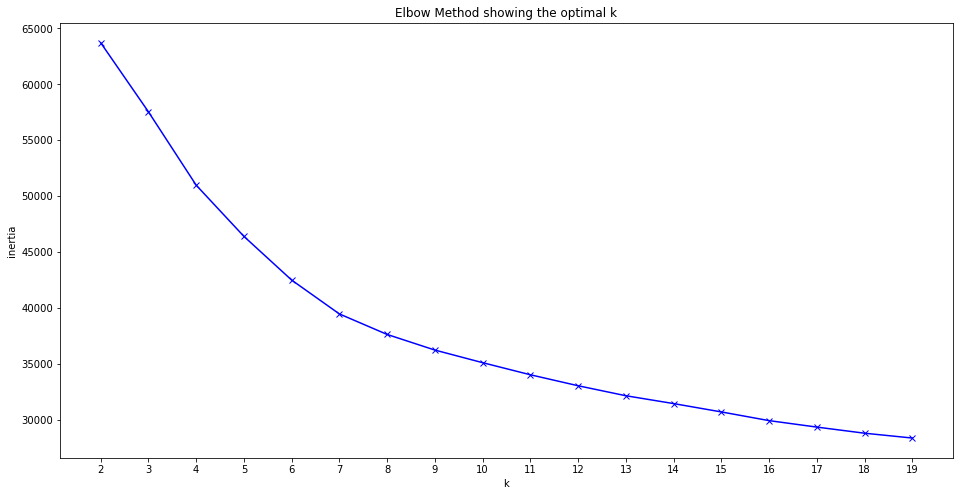

In [70]:
#Elbow method

K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(song_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

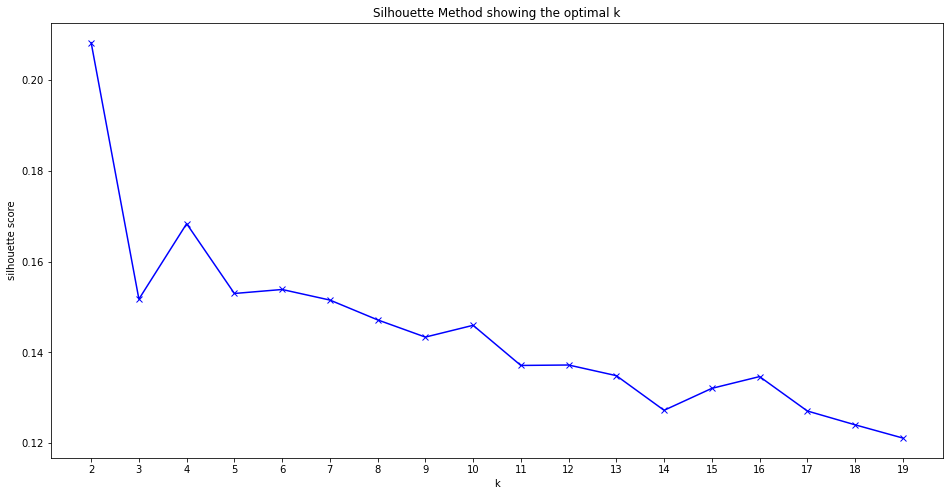

In [71]:
#Silhouette method

K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(song_prep)
    silhouette.append(silhouette_score(song_prep, kmeans.predict(song_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

## K-Means Clustering

In [72]:
kmeans = KMeans(n_clusters=4,random_state=1234)
kmeans.fit(song_prep)

type(kmeans)

sklearn.cluster._kmeans.KMeans

In [73]:
clusters = kmeans.predict(song_prep)
pd.Series(clusters).value_counts().sort_index()

0    2338
1    4363
2    1668
3     154
dtype: int64

In [74]:
final_songdb = pd.DataFrame(songdb)
final_songdb["cluster"] = clusters

final_songdb.head()

,title,artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Peaches (Feat. Daniel Caesar & Giveon),"Justin Bieber, Daniel Caesar, Giveon",0.677,0.696,0,-6.181,0.1190,0.3210,0.000000,0.420,0.464,90.030,1
1,Telepatía,Kali Uchis,0.653,0.524,11,-9.016,0.0502,0.1120,0.000000,0.203,0.553,83.970,0
2,Save Your Tears,The Weeknd,0.680,0.826,0,-5.487,0.0309,0.0212,0.000012,0.543,0.644,118.051,1
3,Montero (Call Me By Your Name),Lil Nas X,0.610,0.508,8,-6.682,0.1520,0.2970,0.000000,0.384,0.758,178.818,1
4,Drivers License,Olivia Rodrigo,0.585,0.436,10,-8.761,0.0601,0.7210,0.000013,0.105,0.132,143.874,2


## Final dataframe (Cluster)

In [75]:
final_songdb.sort_values(by="cluster")

,title,artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
4261,Pretty Face,King Staccz,0.857,0.527,4,-7.586,0.3210,0.16500,0.000000,0.1920,0.5280,129.843,0
5900,Vibe Till We Feel It,"L0Key Wavey, Tnv",0.724,0.583,7,-7.381,0.1780,0.73500,0.000000,0.1500,0.5780,129.706,0
5894,Marissa,"Oprehay, Goldfyr",0.745,0.720,5,-5.291,0.2080,0.02490,0.000000,0.1100,0.8090,96.240,0
2612,Slum Anthem,K Camp,0.759,0.454,1,-6.594,0.1370,0.19200,0.000006,0.0853,0.0551,140.040,0
2613,Lonely,Speaker Knockerz,0.802,0.582,1,-7.296,0.2350,0.12600,0.000000,0.1610,0.3380,150.002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,Animals - Extended,Martin Garrix,0.677,0.866,1,-6.403,0.0392,0.00165,0.662000,0.4120,0.0386,128.005,3
7999,Medicine,Daughter,0.252,0.292,3,-12.303,0.0282,0.11700,0.359000,0.4140,0.1950,95.405,3
530,"Crockett'S Theme - From ""Miami Vice Ii"" Soundt...",Jan Hammer,0.408,0.385,7,-16.604,0.0317,0.42400,0.926000,0.1010,0.3990,191.364,3
576,Brothers In Arms,Dire Straits,0.413,0.296,8,-13.904,0.0277,0.53100,0.801000,0.1830,0.1440,79.273,3


-------------------------------------------------------------------------------------------------------------------------------

# Code 

-------------------------------------------------------------------------------------------------------------------------------

## Parameters

-------------------------------------------------------------------------------------------------------------------------------

In [76]:
#-----------------------------------------Importing libraries------------------------------------------------#


import random
import time


# ----------------------Copies to the dataframes for not replacing them-------------------------------#


billboard_copy = billboard.copy()  

final_songdb_copy = final_songdb.copy()

#----------------------Two possible inputs from the user-----------------------------------------------------#


#x = user's song

#y = yes/not to continue/not


## Main code

-----------------------------------------------------------------------------------------------------------------------------

In [77]:
def Gnoosic():
    
       
# ----------------------------------------------- The App Starts --------------------------------------------------------#
    
    print("\n.......................................::::GNOOSIC®:::::.........................................\n")
    time.sleep(1.5)
        
    
    x=input("Welcome to Gnoosic®, the music recommendator! \n\nEnter the name of a song:").lower()    

    
    bucle=True



    while (bucle): 
        
        
# ---------------------------------------------- Song in top100 ----------------------------------------------------------#
                             
    
        if x.title() in list(billboard_copy['title']): #-(.title converts the first letter of each word into capital letters)
            
            if billboard_copy.shape[0] == 0:
                bucle=False       
                          
            
            print("\nSearching recommendations made for you...")
            
            time.sleep(1.5)
            print("\n.......................................::::GNOOSIC®:::::.........................................\n")
            
            time.sleep(1.5)                
            
            res = billboard_copy.sample()
            billboard_copy.drop(res.index)       
        
        
            print("\n.......................................::::GNOOSIC®:::::.........................................\n")
            time.sleep(1.5)
        
                
            print("\nHere you have our recommendation for you: \n\nSong name:"+" "+ list(res['title'])[0]+"\n\nArtist/s:"+" "+list(res['artist'])[0]) 
            time.sleep(1.5)        
        
        
            print("\n.......................................::::GNOOSIC®:::::.........................................\n")
            time.sleep(1.5)
        
        
        
            y=input("\nDo you want another recommendation based on your song?").lower()
            time.sleep(1.5)                                         
        
                       
        
            if y in"yes":
                time.sleep(1.5)
                continue
                
            else:
                time.sleep(1.5)
                bucle=False
                
                        
                       
            
# ---------------------------------------------- Song not in top100 ----------------------------------------------------------#           
            
    
        if x.title() not in list(billboard_copy['title']):
        #else:
        
        
        
            time.sleep(1.5)     
        
                
            #print("This is not a hot song")        
        
        
            time.sleep(1.5)
            print("\n.......................................::::GNOOSIC®:::::.........................................\n")
        
            audio_feat = audio_features(x)            
            
            scaled_audio_feat = scaler.transform(audio_feat)       
            
            audio_feat_cluster = kmeans.predict(scaled_audio_feat)                     
            
            recomended = final_songdb[final_songdb['cluster']==audio_feat_cluster[0]].sample()
            
            print("\nSearching recommendations made for you...")
            
            time.sleep(1.5)
            print("\n.......................................::::GNOOSIC®:::::.........................................\n")
            
            
            print("\nHere you have our recommendation for you: \n\nSong name:"+" "+ list(recomended['title'])[0]+"\n\nArtist/s:"+" "+list(recomended['artist'])[0]) 
            
            
            time.sleep(1.5)                
          
            print("\n.......................................::::GNOOSIC®:::::.........................................\n")
                
        
        
            y=input("\nDo you want another recommendation based on your song?").lower()
                                                    
        
             
    
            if y in"yes":
                time.sleep(1.5)
                continue
                
            else:
                time.sleep(1.5)
                bucle=False
                
                
                
# ------------------------------------------------ The App ends ----------------------------------------------------------#                 
        
    else:
        bucle=False
        time.sleep(1.5)
        print("\n.......................................::::GNOOSIC®:::::.........................................\n")
        
        print("\nWe hope you enjoyed using Gnoosic! Please be aware for future improvements.")
        print("\nGnoosic is a project of Gnod, by Marek Gibney")
        
        print("\n.......................................::::GNOOSIC®:::::.........................................\n")
        
        
# ------------------------------------------------------------------------------------------------------------------------#       
        
        
            
            

        
        
        
        
        
        
        
        
            
           

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

In [82]:
Gnoosic()


.......................................::::GNOOSIC®:::::.........................................

Welcome to Gnoosic®, the music recommendator! 

Enter the name of a song:lose yourself

.......................................::::GNOOSIC®:::::.........................................


Searching recommendations made for you...

.......................................::::GNOOSIC®:::::.........................................


Here you have our recommendation for you: 

Song name: Lessons In Love

Artist/s: Level 42

.......................................::::GNOOSIC®:::::.........................................


Do you want another recommendation based on your song?no

.......................................::::GNOOSIC®:::::.........................................


We hope you enjoyed using Gnoosic! Please be aware for future improvements.

Gnoosic is a project of Gnod, by Marek Gibney

.......................................::::GNOOSIC®:::::.......................................

---------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

## Testing

In [79]:
#x=input("Welcome to Gnoosic®, the music recommendator! \n\nEnter the name of a song:").lower()        
            
#scaled_audio_feat = scaler.transform(audio_features(x))       
            
#audio_feat_cluster = kmeans.predict(scaled_audio_feat)

#audio_feat_cluster

         
#recomended = final_songdb[final_songdb['cluster']==audio_feat_cluster[0]].sample()            
            
            
#print("\nHere you have our recommendation for you: \n\nSong name:"+" "+ list(recomended['title'])[0]+"\n\nArtist/s:"+" "+list(recomended['artist'])[0]) 
            

In [80]:
final_songdb.sort_values(by="loudness",ascending=False)

,title,artist,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
7540,Big Pimpin',"Jay-Z, Ugk",0.814,0.9560,11,-0.155,0.1720,0.22400,0.007840,0.0477,0.955,138.056,1
5464,Earthquake (Dj Fresh Vs. Diplo) (Feat. Dominiq...,"Dj Fresh, Diplo, Dominique Young Unique",0.736,0.8630,2,-0.165,0.1240,0.00201,0.026300,0.0332,0.183,164.002,1
2410,Good Drank,"2 Chainz, Gucci Mane, Quavo",0.836,0.7760,4,-0.804,0.2390,0.27400,0.000000,0.1130,0.370,130.033,0
715,Every Single Night,Vicky Rai,0.655,0.8940,5,-0.885,0.0440,0.04740,0.000021,0.2460,0.803,130.008,1
6064,No Smoke - Benzi & Blush Remix,"Youngboy Never Broke Again, Benzi, Blush",0.532,0.9560,9,-0.902,0.5910,0.01170,0.000000,0.0528,0.613,150.016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,I'M Drunk And Confused,Sagun,0.706,0.2100,1,-21.867,0.0603,0.74000,0.817000,0.0938,0.246,139.888,3
1717,Carol Of The Bells,"Mykola Dmytrovych Leontovych, John Williams",0.418,0.1060,8,-22.507,0.0448,0.99400,0.029200,0.1790,0.800,46.718,2
5839,Listen Before I Go,Billie Eilish,0.319,0.0561,0,-23.023,0.0450,0.93500,0.003840,0.3880,0.082,79.764,2
5430,Bubble Gum,Clairo,0.509,0.0167,9,-24.639,0.1150,0.97900,0.000027,0.3870,0.229,207.970,2
